# The model pretraining


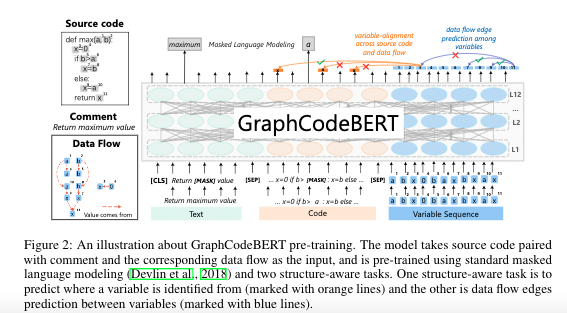

# The model code refinement

## Part I Feature extraction

### 2(a) Process the source code pair into input features

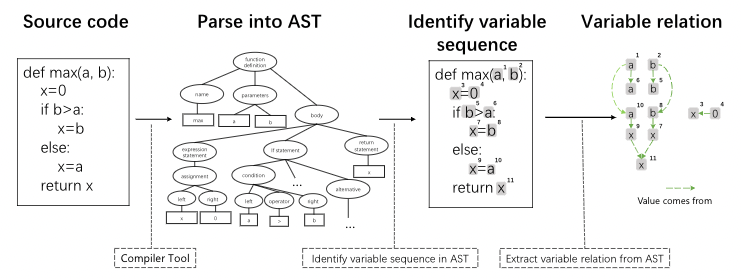

### 2(b) The data flow extraction process
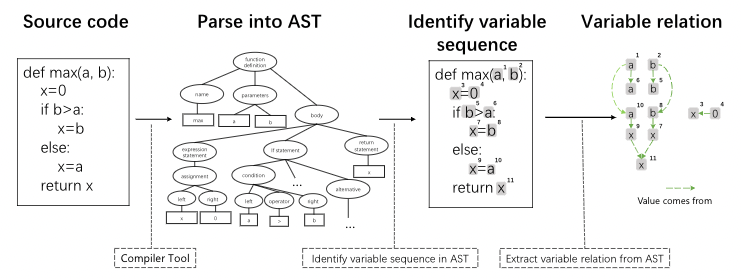


## Part II Fine Tuning


In [1]:
from __future__ import absolute_import
import os
import sys
import pickle
import torch
import json
import random
import logging
import argparse
import numpy as np
import pandas as pd
import itertools 
from io import open
from itertools import cycle
import torch.nn as nn
from model import Seq2Seq
from tqdm import tqdm, trange
from bleu import _bleu
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from torch.utils.data.distributed import DistributedSampler
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaModel, RobertaTokenizer)
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
from parser import DFG_python,DFG_java,DFG_ruby,DFG_go,DFG_csharp,DFG_php,DFG_javascript
from parser import (remove_comments_and_docstrings,
                   tree_to_token_index,
                   index_to_code_token,
                   tree_to_variable_index)
from tree_sitter import Language, Parser

In [2]:
import re
from io import StringIO
import  tokenize
def remove_comments_and_docstrings(source,lang):
    if lang in ['python']:
        """
        Returns 'source' minus comments and docstrings.
        """
        io_obj = StringIO(source)
        print("object:",io_obj)
        out = ""
        prev_toktype = tokenize.INDENT
        last_lineno = -1
        last_col = 0
        for tok in tokenize.generate_tokens(io_obj.readline):
            token_type = tok[0]
            token_string = tok[1]
            start_line, start_col = tok[2]
            end_line, end_col = tok[3]
            ltext = tok[4]
            if start_line > last_lineno:
                last_col = 0
            if start_col > last_col:
                out += (" " * (start_col - last_col))
            # Remove comments:
            if token_type == tokenize.COMMENT:
                pass
            # This series of conditionals removes docstrings:
            elif token_type == tokenize.STRING:
                if prev_toktype != tokenize.INDENT:
            # This is likely a docstring; double-check we're not inside an operator:
                    if prev_toktype != tokenize.NEWLINE:
                        if start_col > 0:
                            out += token_string
            else:
                out += token_string
            prev_toktype = token_type
            last_col = end_col
            last_lineno = end_line
        temp=[]
        for x in out.split('\n'):
            if x.strip()!="":
                temp.append(x)
        return '\n'.join(temp)
    elif lang in ['ruby']:
        return source
    else:
        def replacer(match):
            s = match.group(0)
            if s.startswith('/'):
                return " " # note: a space and not an empty string
            else:
                return s
        pattern = re.compile(
            r'//.*?$|/\*.*?\*/|\'(?:\\.|[^\\\'])*\'|"(?:\\.|[^\\"])*"',
            re.DOTALL | re.MULTILINE
        )
        temp=[]
        for x in re.sub(pattern, replacer, source).split('\n'):
            if x.strip()!="":
                temp.append(x)
        return '\n'.join(temp)

def tree_to_token_index(root_node):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        return [(root_node.start_point,root_node.end_point)]
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_token_index(child)
        return code_tokens
    
def tree_to_variable_index(root_node,index_to_code):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        index=(root_node.start_point,root_node.end_point)
        _,code=index_to_code[index]
        if root_node.type!=code:
            return [(root_node.start_point,root_node.end_point)]
        else:
            return []
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_variable_index(child,index_to_code)
        return code_tokens    

def index_to_code_token(index,code):
    start_point=index[0]
    end_point=index[1]
    if start_point[0]==end_point[0]:
        s=code[start_point[0]][start_point[1]:end_point[1]]
    else:
        s=""
        s+=code[start_point[0]][start_point[1]:]
        for i in range(start_point[0]+1,end_point[0]):
            s+=code[i]
        s+=code[end_point[0]][:end_point[1]]   
    return s
   


In [3]:
logger = logging.getLogger(__name__)
dfg_function={
    'csharp':DFG_csharp,
    'python':DFG_python,
    'java':DFG_java,
    'ruby':DFG_ruby,
    'go':DFG_go,
    'php':DFG_php,
    'javascript':DFG_javascript
}

#load parsers
# parsers={}        
# for lang in dfg_function:
#     LANGUAGE = Language('/Users/apple/Pictures/projects/CodeBERT/GraphCodeBERT/refinement/parser/my-languages.so', lang)
#     parser = Parser()
#     parser.set_language(LANGUAGE) 
#     parser = [parser,dfg_function[lang]]    
#     parsers[lang]= parser


In [4]:
#remove comments, tokenize code and extract dataflow     
def extract_dataflow(code, parser,lang):
    #remove comments
    try:
        code=remove_comments_and_docstrings(code,lang)
    except:
        pass    
    #obtain dataflow
    if lang=="php":
        code="<?php"+code+"?>"    
    try:
        tree = parser[0].parse(bytes(code,'utf8'))    
        root_node = tree.root_node  
        tokens_index=tree_to_token_index(root_node)     
        code=code.split('\n')
        code_tokens=[index_to_code_token(x,code) for x in tokens_index]  
        index_to_code={}
        for idx,(index,code) in enumerate(zip(tokens_index,code_tokens)):
            index_to_code[index]=(idx,code)  
        try:
            DFG,_=parser[1](root_node,index_to_code,{}) 
        except:
            DFG=[]
        DFG=sorted(DFG,key=lambda x:x[1])
        indexs=set()
        for d in DFG:
            if len(d[-1])!=0:
                indexs.add(d[1])
            for x in d[-1]:
                indexs.add(x)
        new_DFG=[]
        for d in DFG:
            if d[1] in indexs:
                new_DFG.append(d)
        dfg=new_DFG
    except:
        dfg=[]
    return code_tokens,dfg


class Example(object):
    """A single training/test example."""
    def __init__(self,
                 source,
                 target,
                 ):
        self.source = source
        self.target = target

def read_examples(filename):
    """Read examples from filename."""
    examples=[]
    source,target=filename.split(',')
    count=0
    with open(source,encoding="utf-8") as f1,open(target,encoding="utf-8") as f2:
        for line1,line2 in zip(f1,f2):
            count=count+1
            line1=line1.strip()
            line2=line2.strip()
            print("line1--",line1)
            print("line2--",line2)
            
                
            examples.append(
                Example(
                    source=line1,
                    target=line2,
                        ) 
            )
    print("how many features",len(examples))        
    saving_file_pkl("data/original/valid",examples) 
    return examples

# A function to save a file in pkl format
def saving_file_pkl(filename,data):
    f = open(filename+".pkl","wb")
    pickle.dump(data,f)
    f.close
    
    
# A function to retrieve files stored in pkl
def retrieve_pkl_file(filename):
    a_file = open(filename+".pkl", "rb")
    output = pickle.load(a_file)
    
    return output

# def read_examples(filename):
#     """Read examples from filename."""
#     examples=[]
#     source,target=filename.split(',')
#     count=0
#     with open(source,encoding="utf-8") as f1,open(target,encoding="utf-8") as f2:
#         for line1,line2 in zip(f1,f2):
            
#             line1=line1.strip()
#             line1=line1.strip('\"')
#             print("line1--",line1)
#             line2 = line2.strip()
#             line2 = line2.strip('\"')
#             print("line2--",line2)
            
#             examples.append(
#                 Example(
#                     source=line1,
#                     target=line2,
#                         ) 
#             )
#             count=count+1
#             if(count == 15):
#                 break

#     return examples

class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 example_id,
                 source_ids,
                 position_idx,
                 dfg_to_code,
                 dfg_to_dfg,                 
                 target_ids,
                 source_mask,
                 target_mask,

    ):
        self.example_id = example_id
        self.source_ids = source_ids
        self.position_idx = position_idx
        self.dfg_to_code = dfg_to_code
        self.dfg_to_dfg = dfg_to_dfg
        self.target_ids = target_ids
        self.source_mask = source_mask
        self.target_mask = target_mask 

In [5]:
def convert_examples_to_features(examples, tokenizer, args,stage=None):
    features = []
    for example_index, example in enumerate(tqdm(examples,total=len(examples))):
        ##extract data flow
        print("******",example)
        code_tokens,dfg=extract_dataflow(example.source,parser['java'],'java')
        code_tokens=[tokenizer.tokenize('@ '+x)[1:] if idx!=0 else tokenizer.tokenize(x) for idx,x in enumerate(code_tokens)]
        ori2cur_pos={}
        ori2cur_pos[-1]=(0,0)
        for i in range(len(code_tokens)):
            ori2cur_pos[i]=(ori2cur_pos[i-1][1],ori2cur_pos[i-1][1]+len(code_tokens[i]))    
        code_tokens=[y for x in code_tokens for y in x]  
        
        #truncating
        code_tokens=code_tokens[:args.max_source_length-3]
        source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
        source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
        position_idx = [i+tokenizer.pad_token_id + 1 for i in range(len(source_tokens))]
        dfg=dfg[:args.max_source_length-len(source_tokens)]
        source_tokens+=[x[0] for x in dfg]
        position_idx+=[0 for x in dfg]
        source_ids+=[tokenizer.unk_token_id for x in dfg]
        padding_length=args.max_source_length-len(source_ids)
        position_idx+=[tokenizer.pad_token_id]*padding_length
        source_ids+=[tokenizer.pad_token_id]*padding_length      
        source_mask = [1] * (len(source_tokens))
        source_mask+=[0]*padding_length        
        
        #reindex
        reverse_index={}
        for idx,x in enumerate(dfg):
            reverse_index[x[1]]=idx
        for idx,x in enumerate(dfg):
            dfg[idx]=x[:-1]+([reverse_index[i] for i in x[-1] if i in reverse_index],)    
        dfg_to_dfg=[x[-1] for x in dfg]
        dfg_to_code=[ori2cur_pos[x[1]] for x in dfg]
        length=len([tokenizer.cls_token])
        dfg_to_code=[(x[0]+length,x[1]+length) for x in dfg_to_code]        

        #target
        if stage=="test":
            target_tokens = tokenizer.tokenize("None")
        else:
            target_tokens = tokenizer.tokenize(example.target)[:args.max_target_length-2]
        target_tokens = [tokenizer.cls_token]+target_tokens+[tokenizer.sep_token]            
        target_ids = tokenizer.convert_tokens_to_ids(target_tokens)
        target_mask = [1] *len(target_ids)
        padding_length = args.max_target_length - len(target_ids)
        target_ids+=[tokenizer.pad_token_id]*padding_length
        target_mask+=[0]*padding_length   
   
        if example_index < 5:
            if stage=='train':
                logger.info("*** Example ***")
                logger.info("source_tokens: {}".format([x.replace('\u0120','_') for x in source_tokens]))
                logger.info("source_ids: {}".format(' '.join(map(str, source_ids))))
                logger.info("source_mask: {}".format(' '.join(map(str, source_mask))))
                logger.info("position_idx: {}".format(position_idx))
                logger.info("dfg_to_code: {}".format(' '.join(map(str, dfg_to_code))))
                logger.info("dfg_to_dfg: {}".format(' '.join(map(str, dfg_to_dfg))))
                
                logger.info("target_tokens: {}".format([x.replace('\u0120','_') for x in target_tokens]))
                logger.info("target_ids: {}".format(' '.join(map(str, target_ids))))
                logger.info("target_mask: {}".format(' '.join(map(str, target_mask))))
       
        features.append(
            InputFeatures(
                 example_index,
                 source_ids,
                 position_idx,
                 dfg_to_code,
                 dfg_to_dfg,
                 target_ids,
                 source_mask,
                 target_mask,
            )
        )
    return features

In [6]:
class TextDataset(Dataset):
    def __init__(self, examples, args):
        self.examples = examples
        self.args=args  
        
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, item):
        #calculate graph-guided masked function
        attn_mask=np.zeros((self.args.max_source_length,self.args.max_source_length),dtype=np.bool)
        #calculate begin index of node and max length of input
        node_index=sum([i>1 for i in self.examples[item].position_idx])
        max_length=sum([i!=1 for i in self.examples[item].position_idx])
        #sequence can attend to sequence
        attn_mask[:node_index,:node_index]=True
        #special tokens attend to all tokens
        for idx,i in enumerate(self.examples[item].source_ids):
            if i in [0,2]:
                attn_mask[idx,:max_length]=True
        #nodes attend to code tokens that are identified from
        for idx,(a,b) in enumerate(self.examples[item].dfg_to_code):
            if a<node_index and b<node_index:
                attn_mask[idx+node_index,a:b]=True
                attn_mask[a:b,idx+node_index]=True
        #nodes attend to adjacent nodes         
        for idx,nodes in enumerate(self.examples[item].dfg_to_dfg):
            for a in nodes:
                if a+node_index<len(self.examples[item].position_idx):
                    attn_mask[idx+node_index,a+node_index]=True  
                    
        return (torch.tensor(self.examples[item].source_ids),
                torch.tensor(self.examples[item].source_mask),
                torch.tensor(self.examples[item].position_idx),
                torch.tensor(attn_mask), 
                torch.tensor(self.examples[item].target_ids),
                torch.tensor(self.examples[item].target_mask),)
    
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
device = device
device

device(type='cpu')

In [8]:
set_seed()
output_dir = "saved_models/small"

In [9]:
config_class, model_class, tokenizer_class = MODEL_CLASSES["roberta"]
config = config_class.from_pretrained("microsoft/graphcodebert-base")
tokenizer = tokenizer_class.from_pretrained("microsoft/graphcodebert-base")

In [10]:
args=[]
# Prepare training data loader
train_examples = read_examples("data/small/valid.buggy-fixed.buggy,data/small/valid.buggy-fixed.fixed")

line1-- public java.util.List < TYPE_1 > METHOD_1 ( ) { java.util.ArrayList < TYPE_1 > VAR_1 = new java.util.ArrayList < TYPE_1 > ( ) ; for ( TYPE_2 VAR_2 : VAR_3 ) { VAR_1 . METHOD_2 ( VAR_2 . METHOD_1 ( ) ) ; } return VAR_1 ; }
line2-- public java.util.List < TYPE_1 > METHOD_1 ( ) { return VAR_1 ; }
line1-- public TYPE_1 < TYPE_2 > METHOD_1 ( TYPE_3 VAR_1 , java.lang.String VAR_2 ) { return METHOD_1 ( VAR_1 . toString ( ) , VAR_2 ) ; }
line2-- public TYPE_1 < TYPE_2 > METHOD_1 ( TYPE_3 VAR_1 , java.lang.String VAR_2 , java.util.HashMap < java.lang.String , java.lang.String > parameters ) { return METHOD_1 ( VAR_1 . toString ( ) , VAR_2 , parameters ) ; }
line1-- public static void main ( java.lang.String [ ] args ) throws java.lang.Exception { TYPE_1 VAR_1 = new TYPE_1 ( ) ; VAR_1 . METHOD_1 ( ) ; VAR_1 . add ( VAR_2 ) ; VAR_1 . METHOD_2 ( true ) ; VAR_1 . init ( STRING_1 ) ; }
line2-- public static void main ( java.lang.String [ ] args ) throws java.lang.Exception { TYPE_1 VAR_1 = n

In [11]:
train_examples2 = read_examples("data/tracer/train_buggy.csv,data/tracer/train_fixed.csv")

line1-- sourceLineAbs
line2-- targetLineAbs
line1-- if ( TypeKind.INT % TypeKind.INT != = TokenKind.LITERAL_INT )
line2-- if ( TypeKind.INT % TypeKind.INT == TokenKind.LITERAL_INT )
line1-- ""
line2-- }
line1-- TypeKind.INT = ( TypeKind.INT * TypeKind.INT ) - TokenKind.LITERAL_INT * TypeKind.INT * TypeKind.INT
line2-- TypeKind.INT = ( TypeKind.INT * TypeKind.INT ) - TokenKind.LITERAL_INT * TypeKind.INT * TypeKind.INT ;
line1-- "printf ( "" \\ \"" "" ! "");"
line2-- "printf ( "" \\ \"" \"" "" ) ;"
line1-- TypeKind.INVALID TypeKind.INVALID
line2-- ""
line1-- if ( TypeKind.INVALID <= TypeKind.INT <= TypeKind.INT + TokenKind.LITERAL_INT ) {
line2-- if ( TypeKind.INT <= TypeKind.INT <= TypeKind.INT + TokenKind.LITERAL_INT ) {
line1-- ""
line2-- }
line1-- "TypeKind.FUNCTIONNOPROTO ( TypeKind.INT , TypeKind.INT , TypeKind.INCOMPLETEARRAY , TypeKind.INT ) ;"
line2-- "TypeKind.FUNCTIONCALL ( TypeKind.INT , TypeKind.INT , TypeKind.INCOMPLETEARRAY , TypeKind.INT ) ;"
line1-- "scanf ( "" %d \n "" 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



how many features 17670


In [12]:
# print(len(train_examples))
# print(len(train_features))
print(train_examples2[3].source)
print(train_examples2[3].target)

TypeKind.INT = ( TypeKind.INT * TypeKind.INT ) - TokenKind.LITERAL_INT * TypeKind.INT * TypeKind.INT
TypeKind.INT = ( TypeKind.INT * TypeKind.INT ) - TokenKind.LITERAL_INT * TypeKind.INT * TypeKind.INT ;


## train_examples[500].source

In [13]:
train_examples[500].target

'private int METHOD_1 ( ) { if ( ( VAR_1 ) == null ) return 0 ; return java.lang.Integer . METHOD_2 ( VAR_1 . getText ( ) . toString ( ) ) ; }'

In [14]:
data2=np.load('temp.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'temp.npy'

In [ ]:
data2=np.load('/Users/apple/Pictures/projects/CodeBERT/GraphCodeBERT/refinement/deepfix/data/network_inputs/iitk-typo-1189/bin_0/examples-train.npy', allow_pickle=True)

In [ ]:
data2


In [ ]:
ori2cur_pos={}
ori2cur_pos[-1]=(0,0)

In [ ]:
print(ori2cur_pos)